In [1]:
import matplotlib.pyplot as plt 
import pandas as pd 
%matplotlib inline
from zipline import run_algorithm
from zipline.api import symbol, order_target_percent, schedule_function, date_rules, time_rules
import pyfolio as pf
import numpy as np

In [2]:
#function initialize
def initialize(context):
    #which stock to trade
    dji = ["AAPL", "AXP", "BA","CAT","CSCO","CVX","DIS","DWDP","GS","HD","IBM","INTC","JNJ","JPM","KO","MCD","MMM","MRK","MSFT","NKE","PFE","PG","TRV","UNH","UTX","V","VZ","WBA","WMT","XOM"]

    #Make list of symbols from the list of tickers
    context.universe = [symbol(s) for s in dji]

    # History window
    context.history_window = 20

    # Size of our portfolio
    context.stocks_to_hold = 10

    # Schedule the daily trading routine for once a month
    schedule_function(handle_data, date_rules.month_start(), time_rules.market_close())


In [3]:
#Calculate month performance
def month_perf(ts):
    perf = (ts[-1]/ts[0]) - 1
    return perf

In [4]:
#function handle_data
def handle_data(context, data):
    # get history for all the stocks
    hist = data.history(context.universe, 'close', context.history_window, '1d')

    # this creates a table of percent returns in order
    perf_table = hist.apply(month_perf).sort_values(ascending=False)

    # make buy list
    buy_list = perf_table[:context.stocks_to_hold]

    # the rest will not be held
    the_rest = perf_table[context.stocks_to_hold:]

    # Place target buy orders for top N stocks
    for stock, perf in buy_list.iteritems():
        stock_weight = 1 / context.stocks_to_hold

        # Place order
        if data.can_trade(stock):
            order_target_percent(stock, stock_weight)

    # Make sure we are flat the rest
    for stock, perf in the_rest.iteritems():
        # Place order with 0 weight
        if data.can_trade(stock):
            order_target_percent(stock, 0.0)

In [5]:
# analyze function
def analyze(context, perf):
    #Use PyFolio to generate a performance report
    returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)
    pf.create_returns_tear_sheet(returns, benchmark_rets=None)


In [6]:
# Set start and end date
start_date = pd.Timestamp('2003-1-1', tz='utc')
end_date = pd.Timestamp('2017-12-31', tz='utc')

Start date,2003-01-02
End date,2017-12-29
Total months,179
,Backtest
Annual return,9.6%
Cumulative returns,295.3%
Annual volatility,18.2%
Sharpe ratio,0.60
Calmar ratio,0.17
Stability,0.78
Max drawdown,-58.2%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,58.17,2007-10-31,2009-03-09,2013-03-22,1408
1,12.98,2015-07-16,2015-08-25,2016-03-11,172
2,11.09,2004-03-05,2004-08-06,2004-10-06,154
3,10.16,2007-07-19,2007-08-16,2007-10-29,73
4,10.00,2003-01-06,2003-03-11,2003-03-21,55


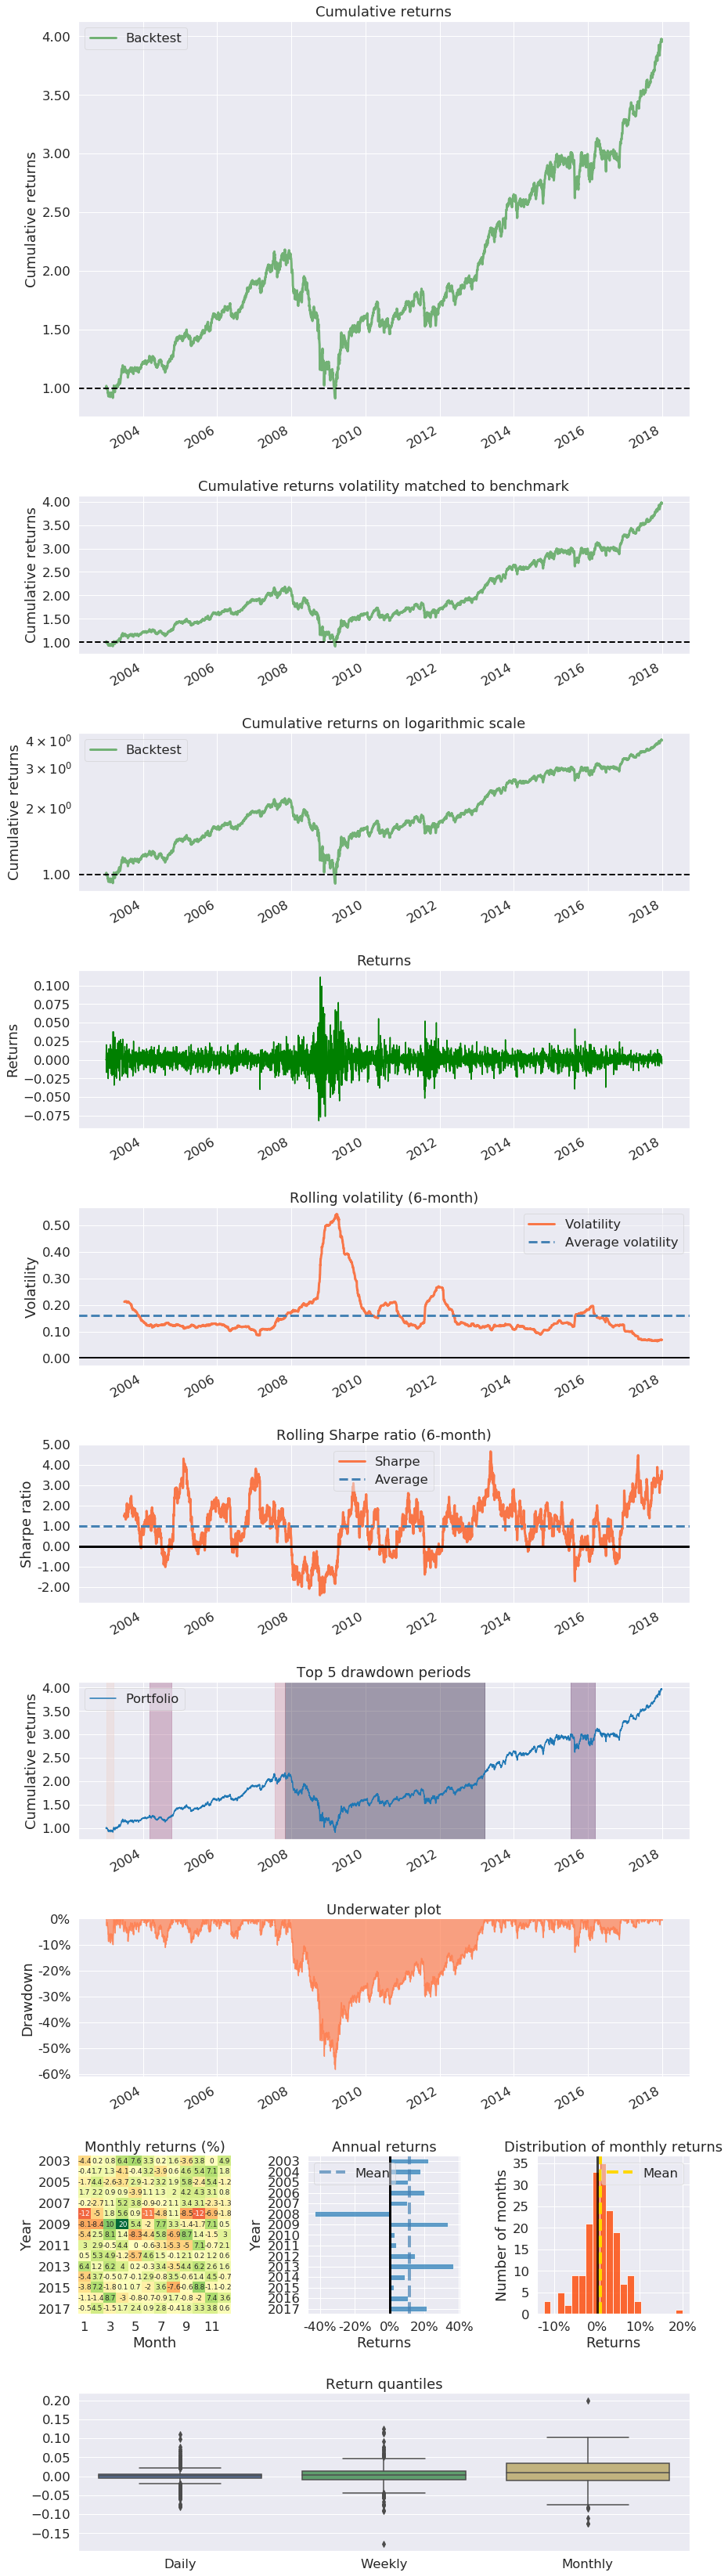

In [7]:
# Fire off the backtest
result = run_algorithm(start=start_date, end=end_date,initialize=initialize, analyze=analyze, capital_base=10000, data_frequency='daily', bundle='quandl')

In [8]:
for column in result:
    print(column)

algo_volatility
algorithm_period_return
alpha
benchmark_period_return
benchmark_volatility
beta
capital_used
ending_cash
ending_exposure
ending_value
excess_return
gross_leverage
long_exposure
long_value
longs_count
max_drawdown
max_leverage
net_leverage
orders
period_close
period_label
period_open
pnl
portfolio_value
positions
returns
sharpe
short_exposure
short_value
shorts_count
sortino
starting_cash
starting_exposure
starting_value
trading_days
transactions
treasury_period_return


In [9]:
result.loc['2010-11-17']

algo_volatility                                                     0.214785
algorithm_period_return                                             0.599224
alpha                                                                   None
benchmark_period_return                                                    0
benchmark_volatility                                                       0
beta                                                                    None
capital_used                                                               0
ending_cash                                                          494.896
ending_exposure                                                      15497.3
ending_value                                                         15497.3
excess_return                                                              0
gross_leverage                                                      0.969054
long_exposure                                                        15497.3

### Day Snapshot

In [10]:
# Lets get a portfolio snapshot
# Select day to view
day = '2009-03-17'

# Get portfolio value and positions for this day
day_positions = result.loc[day, 'positions']
port_value = result.loc[day, 'portfolio_value']

# Empty DataFrame to store values
df = pd.DataFrame(columns=['value', 'pnl'])

# Populate DataFrame with position info
for pos in day_positions:
    ticker = pos['sid'].symbol
    df.loc[ticker, 'value'] = pos['amount'] * pos['last_sale_price']
    df.loc[ticker, 'pnl'] = df.loc[ticker, 'value'] - (pos['amount'] * pos['cost_basis'])

# Add cash position
df.loc['cash', ['value', 'pnl']] = [(port_value - df['value'].sum()), 0]

df

,value,pnl
IBM,1022.01,66.4986
GS,1187.88,121.973
AAPL,1096.26,72.9566
KO,1036.25,-47.3175
CSCO,1081.38,116.701
INTC,1162.2,203.803
WMT,1000,51.9062
V,939.93,15.3309
HD,1031.04,123.819
TRV,1084.59,145.844


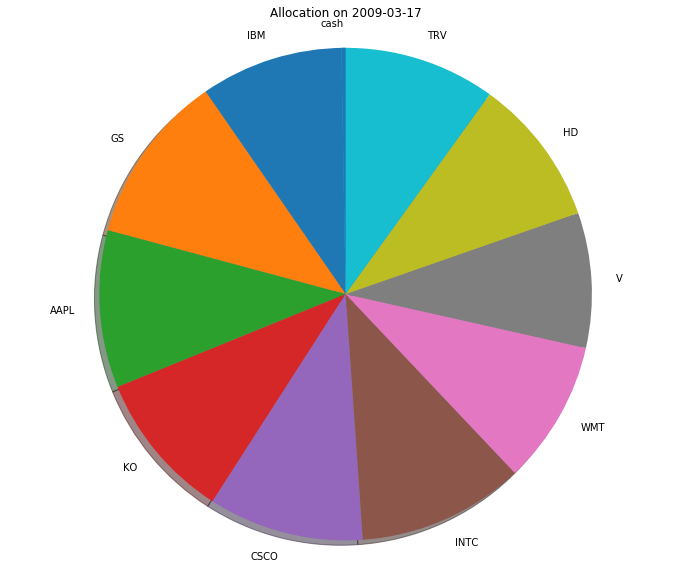

In [11]:
# Make pie chart for allocations
fig, ax1 = plt.subplots(figsize=[12,10])
ax1.pie(df['value'], labels=df.index, shadow=True, startangle=90)
ax1.axis('equal')
ax1.set_title('Allocation on {}'.format(day))
plt.show()

Text(0.5, 1.0, 'Open PnL on 2009-03-17')

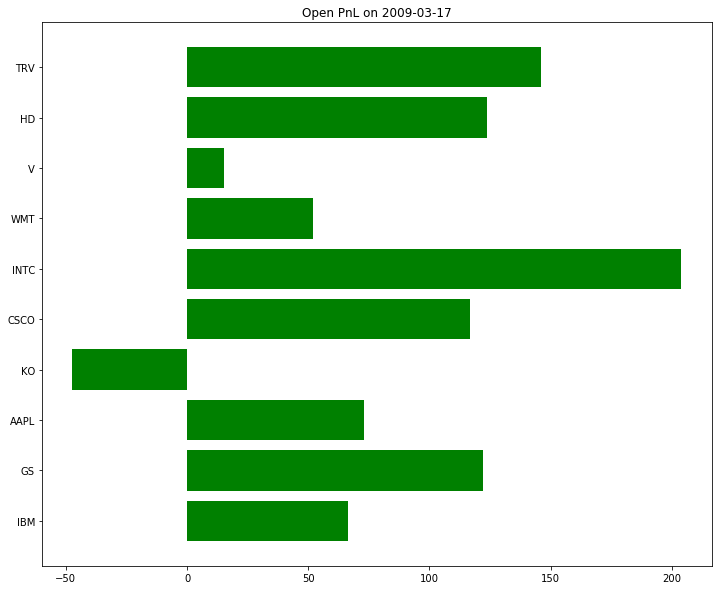

In [12]:
# Make bar chart for open PnL
fig, ax1 = plt.subplots(figsize=[12,10])
pnl_df = df.drop('cash')
ax1.barh(pnl_df.index, pnl_df['pnl'], align='center', color='green', ecolor='black')
ax1.set_title('Open PnL on {}'.format(day))


In [13]:
import matplotlib
import matplotlib.ticker as ticker

# Format for book image
font = {'family': 'eurostile',
'weight': 'normal',
'size': '16'}

matplotlib.rc('font', **font)

In [14]:
# Settings
window = 126
year_lenght = 252

In [15]:
# Copy the columns we need
df = result.copy().filter(items=['portfolio_value', 'gross_leverage'])

### Annualized Return

In [16]:
# AnnualizedReturn = ((EndValue / StartValue ) ^ (YearDays / ActualDays)) - 1


def ann_ret(ts):
    return np.power((ts[-1] / ts[0]), (year_lenght / len(ts))) - 1

### Drawdown

In [17]:
# Function for drawdown
def dd(ts):
    return np.min(ts / np.maximum.accumulate(ts)) - 1

In [18]:
# Get a rolling window
rolling_window = result['portfolio_value'].rolling(window)

In [19]:
# Calculate rolling analytics
df['annualized'] = rolling_window.apply(ann_ret)
df['drawdown'] = rolling_window.apply(dd)

# Drop initial na values
df.dropna(inplace=True)

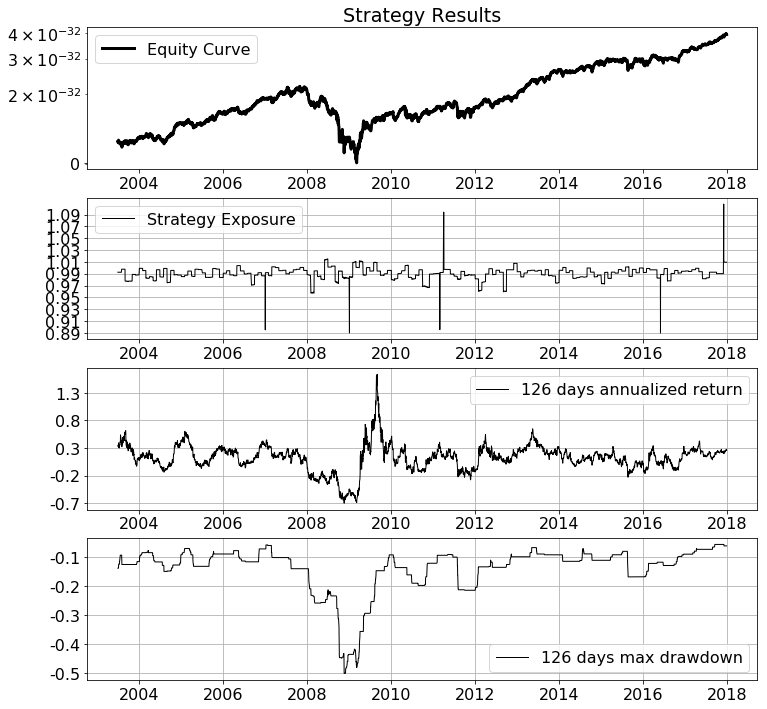

In [40]:
# Make a figure
fig = plt.figure(figsize=(12,12))

# Make the base lower, just to make the graph easier to read
df['portfolio_value'] /= 100

# First chart
ax = fig.add_subplot(411)
ax.set_title('Strategy Results')
ax.plot(df['portfolio_value'], linestyle='-', color='black', label='Equity Curve', linewidth=3.0)

# Set log scale
ax.set_yscale('log')

# Make the axis look nicer
ax.yaxis.set_ticks(np.arange(df['portfolio_value'].min(), df['portfolio_value'].max(), 500))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.0f'))

# Add legend and grid
ax.legend()
ax.grid(False)

# Second chart
ax = fig.add_subplot(412)
ax.plot(df['gross_leverage'], label='Strategy Exposure'.format(window), linestyle='-', color='black', linewidth=1.0)

# Make the axis look nicer
ax.yaxis.set_ticks(np.arange(df['gross_leverage'].min(), df['gross_leverage'].max(), 0.02))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))
ax.legend()
ax.grid(True)

# Third chart
ax = fig.add_subplot(413)
ax.plot(df['annualized'], label='{} days annualized return'.format(window), linestyle='-', color='black', linewidth=1.0)

# Make the axis look nicer
ax.yaxis.set_ticks(np.arange(df['annualized'].min(), df['annualized'].max(), 0.5))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))
ax.legend()
ax.grid(True)

# Forth chart 
ax = fig.add_subplot(414)
ax.plot(df['drawdown'], label='{} days max drawdown'.format(window), linestyle='-', color='black', linewidth=1.0)

#Make the axis look nicer
ax.yaxis.set_ticks(np.arange(df['drawdown'].min(), df['drawdown'].max(), 0.1))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))
ax.legend()
ax.grid(True)